### Compute and store filtered and demodulated velocity field along simulated drifters trajectories

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp
import pyinterp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=7, cores=7) #processes=7, cores=7
#
w = cluster.scale(jobs=6)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f
    
def filt_L(v, h,columns,om, hilbert=False):
    """Call convolve function and returns new dataframe with filtered and demodulated signal
    
    Parameters
    v : input dataframe
    h : filter to use as input in convolve
    columns : columns to filter and demodulate in v
    om : central frequency of h
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    vc : dataframe with new columns with filtered and demodulated signal
    """
    vc = v.copy()
    vc = vc.sort_values('time') #.set_index('time')#
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h=h,hilbert=hilbert)
    if hilbert:
        time = np.arange(0,vc.index.size*dt,dt)#.compute()
        exp = np.exp(-1j*om*2*np.pi*time)
        for V in columns:
            vc[V+'_demodulated'] = vc[V+'_hat']*exp
    return vc

#### Load variables along simulated  drifters trajectories (with time as index)

In [4]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = 'filtered_itide_Tw30_sd_band04'
#trajectory_mean

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df_prime = p[parcels_index]
#df = pa.degs2ms(df) # convert velocities to m/s
df_prime.head()
#print(df.npartitions)
#df = df.get_partition(0).persist()


,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
time,,,,,,,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,0.002438,0.002383,0.002438,0.002383,-0.001410,0.005584,-0.001410,0.005584
2011-11-15,32001255,-69.530426,-126.770836,0.0,0.0,0.0,0.0,0.000518,-0.006434,0.000518,-0.006434,0.002277,-0.000432,0.002277,-0.000432
2011-11-15,24000949,-40.126877,163.312500,0.0,0.0,0.0,0.0,0.028092,0.000022,0.028092,0.000022,-0.018097,-0.020551,-0.018097,-0.020551
2011-11-15,32001165,-65.565285,-130.937500,0.0,0.0,0.0,0.0,-0.004214,-0.001272,-0.004214,-0.001272,0.000220,-0.000716,0.000220,-0.000716
2011-11-15,24001270,-29.922403,177.895828,0.0,0.0,0.0,0.0,-0.027028,0.013208,-0.027028,0.013208,0.014038,0.009028,0.014038,0.009028


In [40]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = 'trajectory' #trajectory

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
#df = pa.degs2ms(df) # convert velocities to m/s
df.head()
print(df.npartitions)
#df = df.get_partition(0).persist()


433


In [9]:
test2 = df.groupby(df.index).get_group(2001296).compute()

<AxesSubplot:xlabel='time'>

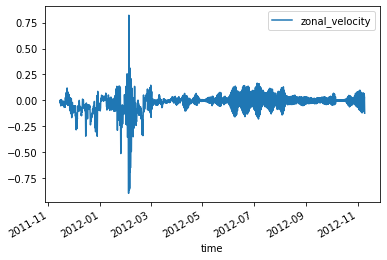

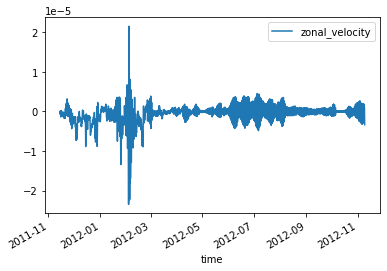

In [10]:
test.plot(x='time',y='zonal_velocity')
test2.plot(x='time',y='zonal_velocity')

In [7]:
time = df.index.compute()
print('Size : ',time.size)
print('Size unique : ',np.unique(time).size)

Size :  734146538
Size unique :  8642


#### Definition of the filter used along each trajectories to keep only the tidal signal

In [41]:
dt = 1/24 # time step in days

#Band pass filter
tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2","K1","O1","M4","S4")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2 #central frequency

V = ['zonal_velocity','meridional_velocity']
Tw = 30 #filter length
dband=0.2 #half bandwidth

# Generate filter for given parameters : Tw, dband, omega (maximize gain for those choices)
h = sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [42]:
#Low pass filter
filter_cutoff = 0.5 # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

import sstats.sigp_AP as sigp
filter_h, filter_t = sigp.lowpass_filter(filter_cutoff, filter_size_pts, dt)
h_hat, w = sigp.filter_response(filter_h, dt)

#### Some cleaning before filtering

In [43]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df



In [44]:
df = df.drop(columns=['temperature','salinity']).persist() #,'temperature','salinity'

In [ ]:
# Remove duplicates found in dataframe and create flag column to check that dt is always 1/24
df_drop = df_prime.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta
                                   ).persist()
df_drop.head()

/dev/shm/pbs.454295.datarmor0/ipykernel_16045/3774279051.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_drop = df_prime.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta


trajectory        lat        lon    z  \
trajectory time                                                         
2000332    2011-11-15 00:00:00     2000332 -68.788177 -21.312500  0.0   
           2011-11-15 01:00:00     2000332 -68.790683 -21.322422  0.0   
           2011-11-15 02:00:00     2000332 -68.793271 -21.332637  0.0   
           2011-11-15 03:00:00     2000332 -68.795857 -21.342816  0.0   
           2011-11-15 04:00:00     2000332 -68.798378 -21.353066  0.0   

                                zonal_velocity  meridional_velocity  \
trajectory time                                                       
2000332    2011-11-15 00:00:00        0.000000             0.000000   
           2011-11-15 01:00:00       -0.114113            -0.080233   
           2011-11-15 02:00:00       -0.113353            -0.079499   
           2011-11-15 03:00:00       -0.114453            -0.079706   
           2011-11-15 04:00:00       -0.114813            -0.076138   

                                sea_level   waterdepth  mean_sea_level  \
trajectory time                                                          
2000332    2011-11-15 00:00:00   0.000000     0.000000       -2.065264   
           2011-11-15 01:00:00  -2.201922  4778.841797       -2.065198   
           2011-11-15 02:00:00  -2.087793  4778.841797       -2.065077   
           2011-11-15 03:00:00  -1.918063  4777.852051       -2.064722   
           2011-11-15 04:00:00  -1.713982  4777.852051       -2.064429   

                                mean_zonal_velocity  mean_meridional_velocity  
trajectory time                                                                
2000332    2011-11-15 00:00:00            -0.032635                  0.001503  
           2011-11-15 01:00:00            -0.032633                  0.001544  
           2011-11-15 02:00:00            -0.032642                  0.001557  
           2011-11-15 03:00:00            -0.032653                  0.001610  
           2011-11-15 04:00:00            -0.032688                  0.001702

In [46]:
# Remove trajectories filled with NaN for some partitions (partition 0 for example), unknown cause
_df_drop = df_drop.drop(columns=['trajectory']).reset_index().dropna(how='all').persist()
#_df_drop = _df_drop.drop(columns=['level_1']).persist()
_df_drop.head()

,trajectory,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,waterdepth,mean_sea_level,mean_zonal_velocity,mean_meridional_velocity
0,2000332,2011-11-15 00:00:00,-68.788177,-21.312500,0.0,0.000000,0.000000,0.000000,0.000000,-2.065264,-0.032635,0.001503
1,2000332,2011-11-15 01:00:00,-68.790683,-21.322422,0.0,-0.114113,-0.080233,-2.201922,4778.841797,-2.065198,-0.032633,0.001544
2,2000332,2011-11-15 02:00:00,-68.793271,-21.332637,0.0,-0.113353,-0.079499,-2.087793,4778.841797,-2.065077,-0.032642,0.001557
3,2000332,2011-11-15 03:00:00,-68.795857,-21.342816,0.0,-0.114453,-0.079706,-1.918063,4777.852051,-2.064722,-0.032653,0.001610
4,2000332,2011-11-15 04:00:00,-68.798378,-21.353066,0.0,-0.114813,-0.076138,-1.713982,4777.852051,-2.064429,-0.032688,0.001702


In [47]:
test_drop = _df_drop.groupby('trajectory').get_group(2001296).compute()

<AxesSubplot:xlabel='time'>

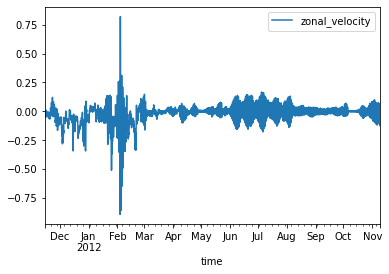

In [48]:
test_drop.plot(x='time',y='zonal_velocity')

In [49]:
columns = ['zonal_velocity','meridional_velocity']
for V in columns:
    _df_drop[V+'_iprime'] = _df_drop[V].sub(_df_drop['mean_'+V])
_df_drop = _df_drop.persist()

#### Filter and demodulation (cf doc overleaf for formula) : 
Along each trajectory:

1) Apply the filter, h, near the semi-diurnal tidal frequency, $\omega$

2) Demodulation of the filtered signal (*$e^{i\omega t}$)

In [50]:
df_filtered = _df_drop.groupby('trajectory').apply(filt_L,filter_h,['zonal_velocity_iprime','meridional_velocity_iprime']
                                                  ,omega,hilbert=False).persist()
df_filtered.head()

/dev/shm/pbs.454295.datarmor0/ipykernel_16045/3425319128.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = _df_drop.groupby('trajectory').apply(filt_L,filter_h,['zonal_velocity_iprime','meridional_velocity_iprime']


trajectory                time        lat        lon    z  \
trajectory                                                                
2000332    0     2000332 2011-11-15 00:00:00 -68.788177 -21.312500  0.0   
           1     2000332 2011-11-15 01:00:00 -68.790683 -21.322422  0.0   
           2     2000332 2011-11-15 02:00:00 -68.793271 -21.332637  0.0   
           3     2000332 2011-11-15 03:00:00 -68.795857 -21.342816  0.0   
           4     2000332 2011-11-15 04:00:00 -68.798378 -21.353066  0.0   

              zonal_velocity  meridional_velocity  sea_level   waterdepth  \
trajectory                                                                  
2000332    0        0.000000             0.000000   0.000000     0.000000   
           1       -0.114113            -0.080233  -2.201922  4778.841797   
           2       -0.113353            -0.079499  -2.087793  4778.841797   
           3       -0.114453            -0.079706  -1.918063  4777.852051   
           4       -0.114813            -0.076138  -1.713982  4777.852051   

              mean_sea_level  mean_zonal_velocity  mean_meridional_velocity  \
trajectory                                                                    
2000332    0       -2.065264            -0.032635                  0.001503   
           1       -2.065198            -0.032633                  0.001544   
           2       -2.065077            -0.032642                  0.001557   
           3       -2.064722            -0.032653                  0.001610   
           4       -2.064429            -0.032688                  0.001702   

              zonal_velocity_iprime  meridional_velocity_iprime  \
trajectory                                                        
2000332    0               0.032635                   -0.001503   
           1              -0.081481                   -0.081777   
           2              -0.080711                   -0.081056   
           3              -0.081800                   -0.081316   
           4              -0.082126                   -0.077840   

              zonal_velocity_iprime_hat  meridional_velocity_iprime_hat  
trajectory                                                               
2000332    0                  -0.016854                       -0.034280  
           1                  -0.020868                       -0.036714  
           2                  -0.024862                       -0.039110  
           3                  -0.028816                       -0.041454  
           4                  -0.032708                       -0.043733

In [51]:
df_filtered = df_filtered.reset_index(drop=True).persist()

In [56]:
np.unique(df_filtered.dropna(subset=['time']).time.compute())

array(['2011-11-15T00:00:00.000000000', '2011-11-15T01:00:00.000000000',
       '2011-11-15T02:00:00.000000000', ...,
       '2012-11-08T23:00:00.000000000', '2012-11-09T00:00:00.000000000',
       '2012-11-09T01:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
df_filtered = df_filtered.dropna(subset=['time']).persist()

In [59]:
df_filtered = df_filtered.set_index('time').persist()
df_filtered.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,waterdepth,mean_sea_level,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_iprime,meridional_velocity_iprime,zonal_velocity_iprime_hat,meridional_velocity_iprime_hat
time,,,,,,,,,,,,,,,
2011-11-15,2000332,-68.788177,-21.312500,0.0,0.0,0.0,0.0,0.0,-2.065264,-0.032635,0.001503,0.032635,-0.001503,-0.016854,-0.034280
2011-11-15,26000448,7.831545,132.062500,0.0,0.0,0.0,0.0,0.0,0.969504,-0.133159,0.033771,0.133159,-0.033771,0.187673,-0.177882
2011-11-15,26000607,3.034701,139.354172,0.0,0.0,0.0,0.0,0.0,1.009348,-0.041734,0.051182,0.041734,-0.051182,-0.032613,-0.141249
2011-11-15,26001135,9.751602,161.229172,0.0,0.0,0.0,0.0,0.0,0.933084,-0.196169,0.049958,0.196169,-0.049958,0.165535,-0.042095
2011-11-15,26001184,8.802592,163.312500,0.0,0.0,0.0,0.0,0.0,0.909380,-0.127678,0.037334,0.127678,-0.037334,0.170332,-0.061231


In [16]:
# Check duplicates

time = df_filtered[df_filtered.trajectory==29000231].index.compute()

In [17]:
print('Duplicates: ', time.size!=np.unique(time).size)
if time.size!=np.unique(time).size:
    print('Number of duplicates : ',time.size-np.unique(time).size)

Duplicates:  False


#### Create and store dask dataframe with real and imaginary part of the analytic signal and demodulated signal for velocity fields

In [17]:
for v in ["zonal_velocity_iprime","meridional_velocity_iprime"]:
    df_filtered[v+"_hat_real"] = df_filtered[v+"_hat"].map_partitions(lambda x : np.real(x)).persist()

#    df_filtered[v+"_hat_imag"] = df_filtered[v+"_hat"].map_partitions(lambda x : np.imag(x)).persist()
#    df_filtered[v+"_demodulated_real"] = df_filtered[v+"_demodulated"].map_partitions(lambda x : np.real(x)).persist()
#    df_filtered[v+"_demodulated_imag"] = df_filtered[v+"_demodulated"].map_partitions(lambda x : np.imag(x)).persist()

In [18]:
for v in ["zonal_velocity_iprime","meridional_velocity_iprime"]:
    df_filtered = df_filtered.drop(columns=[v+"_hat"]).persist() #,v+"_demodulated"

In [16]:
df_filtered

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,mean_sea_level,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_iprime,meridional_velocity_iprime,zonal_velocity_iprime_hat,meridional_velocity_iprime_hat
npartitions=599,,,,,,,,,,,,,,
2011-11-15 00:00:00.000000000,int64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64
2011-11-15 00:59:40.180419072,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 00:00:00.000000000,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 01:00:00.000000000,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [60]:
# Store filtered demodulated dataframe
# Title is defined as follow : filtered_itide_Tw{filter length}_sd_band{bandwidth}
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_filtered, overwrite=True, name="lpass_filtered_iprime_05cpd")

No reindexing
deleting existing archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/lpass_filtered_iprime_05cpd
create new archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/lpass_filtered_iprime_05cpd


'/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/parquets/lpass_filtered_iprime_05cpd'

In [21]:
lon,lat,low_u = df_filtered.lon.compute(),df_filtered.lat.compute(),df_filtered.zonal_velocity_hat_real.compute()


In [22]:
plt.scatter(lon[::6],lat[::6],c=low_u[::6])

Error in callback <function flush_figures at 0x2aabc45fe820> (for post_execute):


KeyboardInterrupt: 

In [22]:
# Cell to load the filtered signal
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = 'filtered_itide_Tw30_sd_band04'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
time,,,,,,,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,0.002438,0.002383,0.002438,0.002383,-0.001410,0.005584,-0.001410,0.005584
2011-11-15,32001255,-69.530426,-126.770836,0.0,0.0,0.0,0.0,0.000518,-0.006434,0.000518,-0.006434,0.002277,-0.000432,0.002277,-0.000432
2011-11-15,24000949,-40.126877,163.312500,0.0,0.0,0.0,0.0,0.028092,0.000022,0.028092,0.000022,-0.018097,-0.020551,-0.018097,-0.020551
2011-11-15,32001165,-65.565285,-130.937500,0.0,0.0,0.0,0.0,-0.004214,-0.001272,-0.004214,-0.001272,0.000220,-0.000716,0.000220,-0.000716
2011-11-15,24001270,-29.922403,177.895828,0.0,0.0,0.0,0.0,-0.027028,0.013208,-0.027028,0.013208,0.014038,0.009028,0.014038,0.009028


In [23]:
df_test = df[df.trajectory==29000231].compute()

<AxesSubplot:xlabel='time'>

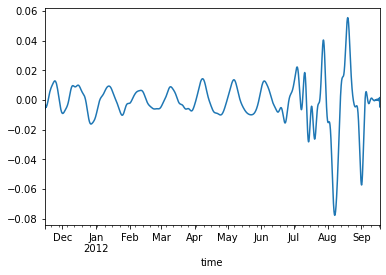

In [24]:
df_test.zonal_velocity_demodulated_real.plot()

In [ ]:
cluster.close()